In [70]:
import sys
import pandas as pd
import numpy as np
import math
import pickle
from sklearn import datasets

class DecisionNode:
    def __init__(self, depth = 0, max_depth = -1, min_leaf = 1):
        self._left_child = None
        self._right_child = None
        self._depth = depth
        self._max_depth = max_depth
        self._min_leaf = min_leaf
        
    def _divide(self, data_set, column, condition):
        if isinstance(condition, str):
            part_a = data_set[data_set[column] == condition]
            part_b = data_set[data_set[column] != condition]
        else:
            part_a = data_set[data_set[column] >= condition]
            part_b = data_set[data_set[column] < condition]
        return part_a, part_b
    
    def _entropy(self, labels):
        counts = labels.value_counts()
        total = sum(counts)
        entropy = -counts.map(lambda c: (c/total) * math.log2(c/total)).sum()
        return entropy
    
    def _entropy_sum(self, set_a, set_b):
        size_a = set_a.shape[0]
        size_b = set_b.shape[0]
        total = size_a + size_b
        total_entropy = size_a / total * self._entropy(set_a) + size_b / total * self._entropy(set_b)
        return total_entropy
    
    def _information_gain(self,data_set, column, condition):
        set_a, set_b = self._divide(data_set, column, condition)
        gain = self._entropy(data_set.iloc[:, -1]) - self._entropy_sum(set_a.iloc[:,-1], set_b.iloc[:,-1])
        return gain
    
    def fit(self, data_set, selected_features = None):
        if selected_features is None:
            columns = data_set.columns.values.tolist()
            selected_features = columns[:-1]
        
        best_gain = 0
        best_split_col = None
        best_split_value = None

        for column_name in selected_features:
            current_column = data_set[column_name]
            unique_values = current_column.unique().tolist()
            for value in unique_values:
                gain = self._information_gain(data_set, column_name, value)
                if gain > best_gain:
                    best_gain = gain
                    best_split_col = column_name
                    best_split_value = value
                    
        self._best_split_col = best_split_col
        self._best_split_value = best_split_value
        
        if best_gain > 0 and (self._max_depth == -1 or self._depth < self._max_depth):
            set_a, set_b = self._divide(data_set, best_split_col, best_split_value)
            if (set_b.shape[0] >= self._min_leaf) & (set_a.shape[0] >= self._min_leaf):
                self._left_child = DecisionNode(self._depth + 1, self._max_depth, self._min_leaf)
                self._left_child.fit(set_a)

                self._right_child = DecisionNode(self._depth + 1, self._max_depth, self._min_leaf)
                self._right_child.fit(set_b)
            else:
                self._leaf_value = (data_set.iloc[:,-1].value_counts()[data_set.iloc[:,-1].value_counts() == data_set.iloc[:,-1].value_counts().max()].sample(1)).index[0]
#                 self._leaf_value = data_set.iloc[:,-1].value_counts()[data_set.iloc[:,-1].value_counts() == data_set.iloc[:,-1].value_counts().max()].index[0]
                    
            
        else:
            self._leaf_value = (data_set.iloc[:,-1].value_counts()[data_set.iloc[:,-1].value_counts() == data_set.iloc[:,-1].value_counts().max()].sample(1)).index[0]
#             self._leaf_value = data_set.iloc[:,-1].value_counts()[data_set.iloc[:,-1].value_counts() == data_set.iloc[:,-1].value_counts().max()].index[0]
            
    def predict_single(self, record):
        if self._left_child is None and self._right_child is None:
            return self._leaf_value
        else:
            if isinstance(self._best_split_value, str):
                go_left = record[self._best_split_col] == self._best_split_value
            else:
                go_left = record[self._best_split_col] >= self._best_split_value
                
            if go_left:
                return self._left_child.predict_single(record)
            else:
                return self._right_child.predict_single(record)
    
    def predict(self, data_set):
        return data_set.apply(self.predict_single, axis=1)
        
    
    def __repr__(self):
        tree_str = '\t' * self._depth + '>'
        if self._left_child == None and self._right_child == None:
            tree_str += 'LEAF: {}\n'.format(self._leaf_value)
        else:
            tree_str += "Split {} on {}\n".format(self._best_split_col, self._best_split_value)
            tree_str += str(self._left_child)
            tree_str += str(self._right_child)
        return tree_str



In [83]:
data_set_raw = datasets.load_iris()
data_set = pd.DataFrame(data_set_raw.data)
data_set.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
data_set['iris_type'] = pd.DataFrame(data_set_raw.target)

,sepal_length,sepal_width,petal_length,petal_width,iris_type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [8]:
X = pd.DataFrame(data_set_raw.data)
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
y = pd.DataFrame(data_set_raw.target)
y.columns = ['iris_type']
X['iris_type'] = y
data_set = X

In [69]:
(1 >= 0) & (2 >= 1)

True

In [50]:
# selected_rows = np.random.choice(data_set.shape[0] - 1, int(data_set.shape[0] / 3))
selected_rows = np.arange(0, 17, 1)
# selected_features = np.random.choice(data_set.columns.tolist()[:-1], int(np.ceil(np.sqrt(int(data_set.shape[1])))), replace=False)
selected_features = ['Weight', 'Height']
decision_tree = DecisionNode(max_depth = 40, min_leaf = 1)
decision_tree.fit(data_set.iloc[selected_rows,:], selected_features)
predict = decision_tree.predict(data_set)
predict

0     Cat
1     Cat
2     Cat
3     Cat
4     Cat
5     Cat
6     Cat
7     Cat
8     Cat
9     Cat
10    Dog
11    Dog
12    Dog
13    Dog
14    Dog
15    Dog
16    Dog
dtype: object

In [51]:
selected_features = np.random.choice(data_set.columns.tolist()[:-1], int(np.ceil(np.sqrt(int(data_set.shape[1])))), replace=False)
selected_features

array(['Weight', 'Height'], dtype='<U6')

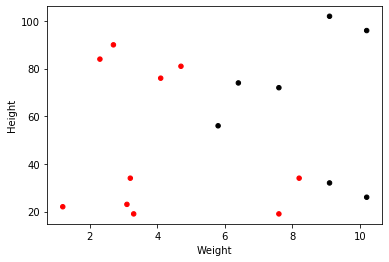

In [52]:
data = pd.DataFrame([#Standard cats
                     ['Cat', 4.7, 81], 
                     ['Cat', 3.1, 23], 
                     ['Cat', 2.3, 84], 
                     ['Cat', 1.2, 22], 
                     ['Cat', 3.3, 19], 
                     ['Cat', 2.7, 90],
                     ['Cat', 4.1, 76],
                     ['Cat', 3.2, 34],
                     #Fat cats
                     #['Cat', 6.1, 23],
                     ['Cat', 8.2, 34],
                     ['Cat', 7.6, 19],
                     #Dogs
                     ['Dog', 6.4, 74],
                     ['Dog', 7.6, 72],
                     ['Dog', 5.8, 56],
                     ['Dog', 9.1, 102],
                     ['Dog', 10.2, 96],
                     #Fat Dogs
                     ['Dog', 9.1, 32],
                     ['Dog', 10.2, 26]],
                    columns = ['Species', 'Weight', 'Height'])

data_set = data[['Weight', 'Height','Species']]

data.plot.scatter(x='Weight', y='Height', c=np.where(data.Species=='Cat','red','black'))

In [77]:
# selected_rows = np.random.choice(data_set.shape[0] - 1, int(data_set.shape[0] / 3))
selected_rows = np.arange(0, 17, 1)
# selected_features = np.random.choice(data_set.columns.tolist()[:-1], int(np.ceil(np.sqrt(int(data_set.shape[1])))), replace=False)
selected_features = ['Weight', 'Height']
decision_tree = DecisionNode(max_depth=3, min_leaf=3)
decision_tree.fit(data_set.iloc[selected_rows,:], selected_features)
predict = decision_tree.predict(data_set)

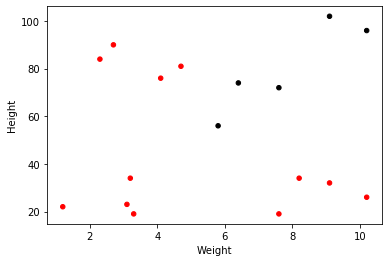

In [78]:
plot_predict = data
plot_predict['Species'] = predict
plot_predict.plot.scatter(x='Weight', y='Height', c=np.where(data.Species=='Cat','red','black'))

In [72]:
(1 > 0) & (2 > 1) 

True